In [2]:
# model wrapper
import sys
import os
sys.path.append(os.getenv('BONNER_ROOT_PATH'))
from tqdm import tqdm
import pickle
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
#from model_evaluation.results.predicting_brain_data.performance_plots import *
from data_tools.config import ACTIVATIONS_PATH

DATASET, MODE = 'places', None
HOOK = None
MAX_POOL = True

# SVM Classification

In [9]:
def train(features, labels, estimator_type, shuffle = True, num_folds=10):

    
    features = normalize(features)
    splits = create_splits(n = len(features), shuffle = shuffle, num_folds=num_folds)
        
    _y_true, _y_pred, _y_prob = [], [], []
    
    for indices_test in tqdm(splits):
        
        if estimator_type == 'svm':
            classifier = svm.SVC(probability=True)


        if estimator_type == 'logistic':
            classifier = LogisticRegression()
            

        
        indices_train = np.setdiff1d(np.arange(0, len(features)), np.array(indices_test))
        X_train, y_train = features[indices_train,...], labels[indices_train,...]
        X_test, y_test = features[indices_test,...], labels[indices_test,...]
        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
            
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        y_prob = classifier.predict_proba(X_test)
        
        _y_true.append(y_test)
        _y_pred.append(y_pred)
        _y_prob.append(y_prob)
            
    return _y_true, _y_pred, _y_prob 

## expansion model

In [21]:
model_info =   {
                'iden':'expansion_model_final',
                'model':ExpansionModel(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':3,
                'num_features':10000,
                'max_pool':MAX_POOL,
}
    
activations_identifier = get_activations_iden(model_info, DATASET, MODE)

# get model activations  
activations = Activations(model=model_info['model'],
                        layer_names=model_info['layers'],
                        dataset=DATASET,
                        preprocess=model_info['preprocess'],
                        mode = MODE,
                        _hook = HOOK,
                         batch_size = 50)

activations.get_array(ACTIVATIONS_PATH,activations_identifier) 
data = xr.open_dataset(os.path.join(ACTIVATIONS_PATH,activations_identifier))
data_subset = data.where(data.stimulus_id.isin(val_images_subset),drop=True).x.values
labels_subset = np.array([cat_dict_subset[i] for i in val_images_subset])
    
y_true, y_pred, y_prob = train(features = data_subset, labels = labels_subset, 
                     estimator_type = 'svm', shuffle = True, num_folds=5)

array is already saved in /data/atlas/activations as expansion_model_final_mp_3_layers_10000_features_places


  0%|                                           | 0/5 [00:00<?, ?it/s]

(8000, 256) (8000,)
(2000, 256) (2000,)


 20%|███████                            | 1/5 [01:02<04:08, 62.21s/it]

(8000, 256) (8000,)
(2000, 256) (2000,)


 40%|██████████████                     | 2/5 [02:04<03:06, 62.22s/it]

(8000, 256) (8000,)
(2000, 256) (2000,)


 60%|█████████████████████              | 3/5 [03:06<02:04, 62.30s/it]

(8000, 256) (8000,)
(2000, 256) (2000,)


 80%|████████████████████████████       | 4/5 [04:08<01:02, 62.11s/it]

(8000, 256) (8000,)
(2000, 256) (2000,)


100%|███████████████████████████████████| 5/5 [05:06<00:00, 61.32s/it]


In [22]:
top_1, top_5 = [], [] 

for i in range(len(y_true)):
    top_1.append(top_k(y_true[i], y_prob[i], k=1))
    top_5.append(top_k(y_true[i], y_prob[i], k=5))

print('top_1:',sum(top_1)/len(top_1))
print('top_5:',sum(top_5)/len(top_5))

top_1: 0.09690000000000001
top_5: 0.28659999999999997


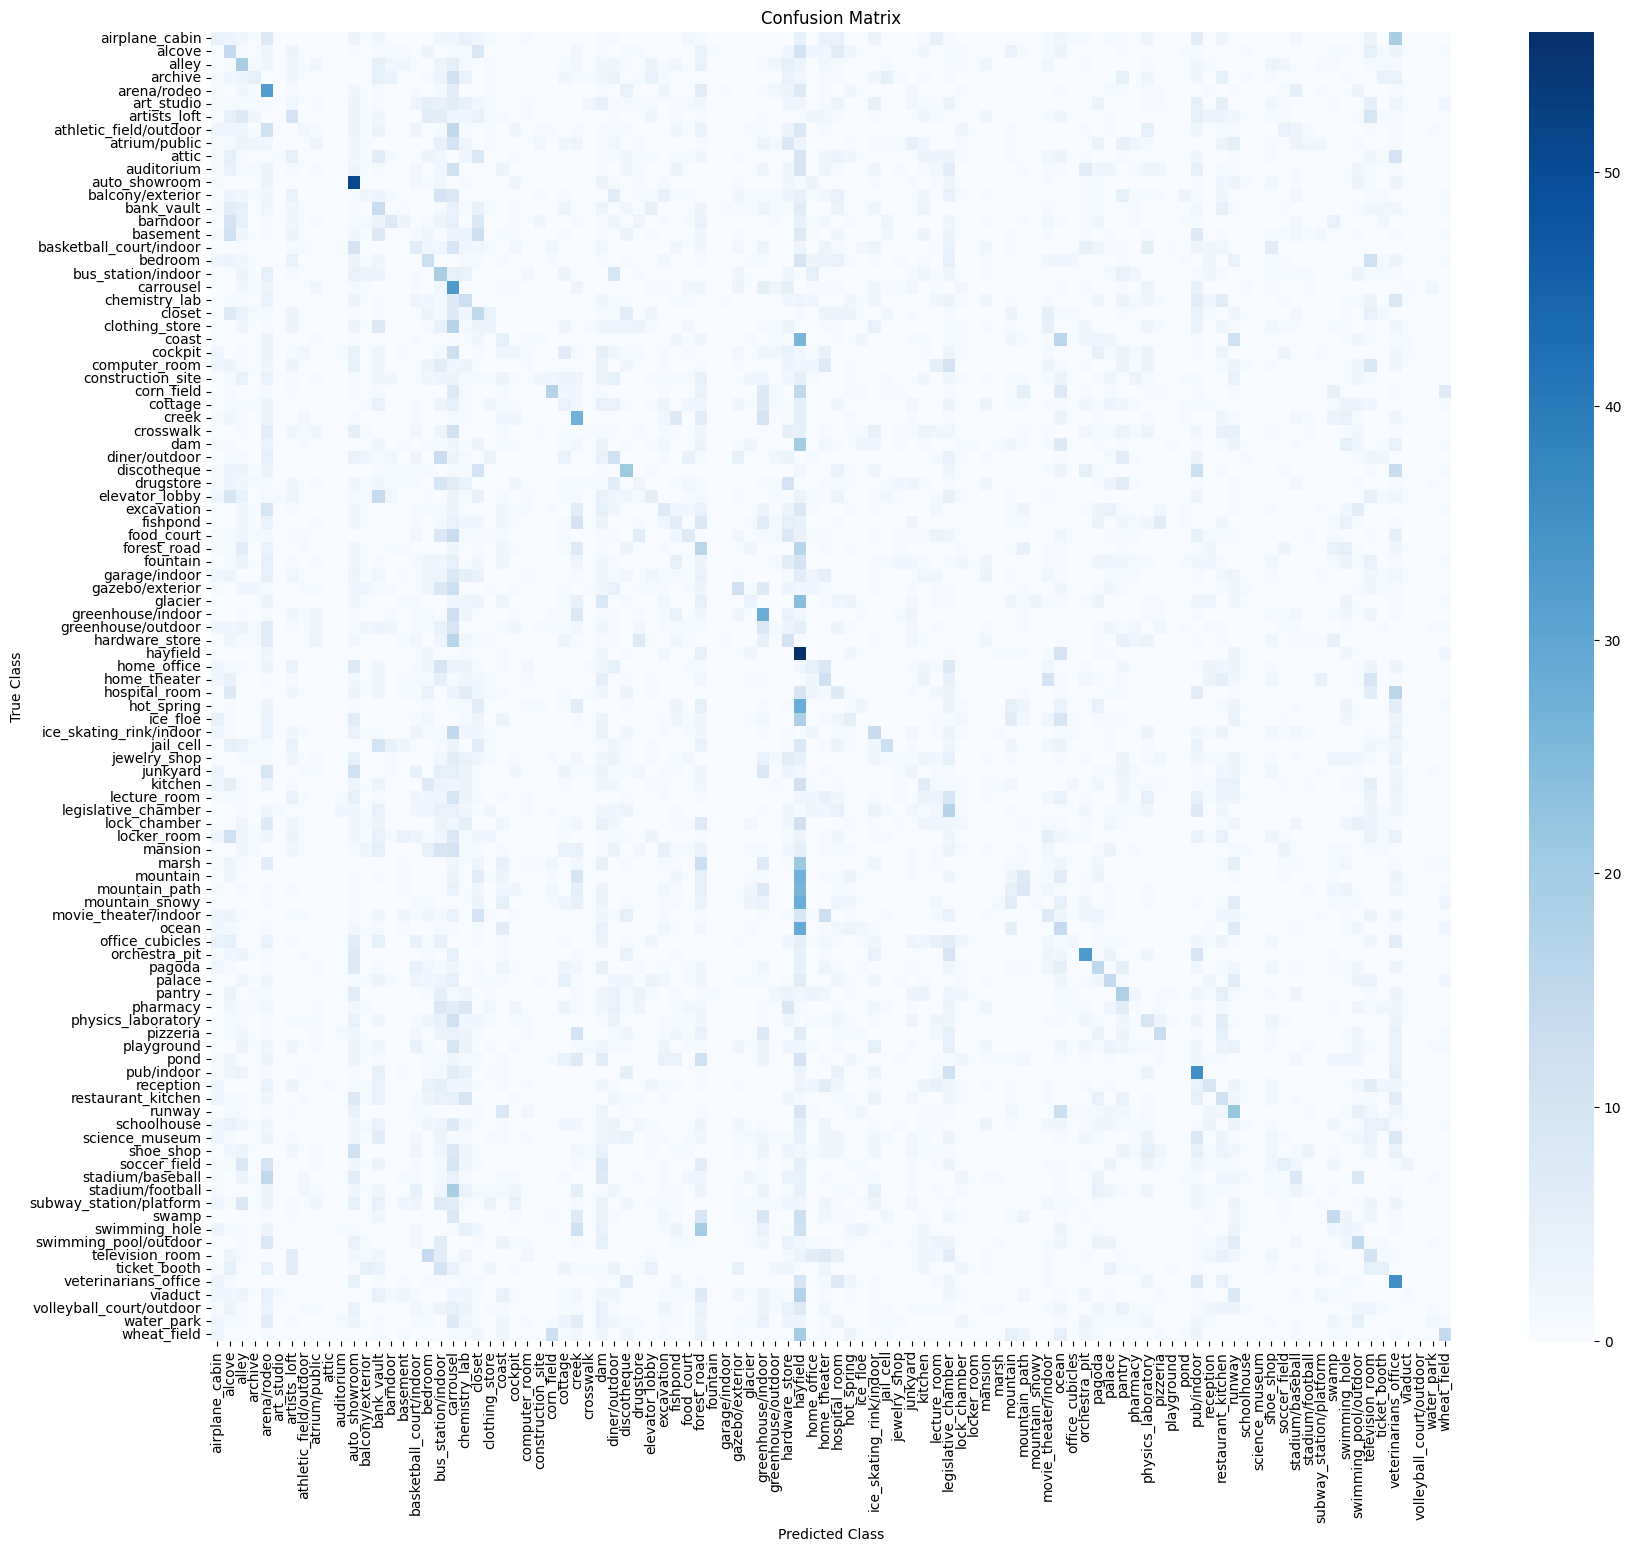

In [34]:
_y_true, _y_pred = [], []

for i in range(5):
    _y_true.extend(y_true[i])
    _y_pred.extend(y_pred[i])   
  
    
cm_expansion = confusion_matrix(_y_true, _y_pred, labels=sorted(cat_subset))
with open('cm_expansion','wb') as f:
    pickle.dump(cm_expansion, f)

class_names = [CAT_NAMES[i] for i in sorted(cat_subset)]

fig = plt.figure(figsize=(20, 17),dpi=100)
sns.heatmap(cm_expansion, annot=False, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.savefig(f'cm_expansion.png', dpi=100)
plt.show()